<a href="https://colab.research.google.com/github/westonjackson/wordle_solver/blob/main/Wordle_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Corpus

In [1]:
from nltk import FreqDist
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('wordle_targets').sheet1
rows = worksheet.get_all_values()
targetlist = [x[0] for x in rows]

In [3]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('wordle_guesses').sheet1
rows = worksheet.get_all_values()
guesslist = [x[0] for x in rows]

In [4]:
len(guesslist), len(targetlist)

(10657, 2315)

# Wordle Solver Utils

In [5]:
# we can only consider five-letter-words
def is_valid_wordle(s):
  return (len(s) == 5) and s.isalpha()

# initialize candidates from corpus
def initialize_candidates():
  frequency_list = FreqDist(targetlist)
  return [s for s, _ in frequency_list.most_common() if is_valid_wordle(s)]

def evaluate(word, target):
  result = []
  target_counts = defaultdict(int)
  for i in range(5):
    c = word[i]
    t = target[i]
    if t == c:
      result.append(2)
    else:
      result.append(0)
      target_counts[t] += 1
  
  for i in range(5):
    c = word[i]
    if result[i] == 2:
      continue
    if target_counts[c] > 0:
      target_counts[c] -= 1
      result[i] = 1

  return tuple(result)

def prune_wordle_candidates(candidate_df, word, result):
  cols = candidate_df.columns.tolist()
  for i in range(5):
    c = word[i]
    if result[i] == 2:
      cols.remove(i)
      candidate_df = candidate_df[candidate_df[i] == c]
    else:
      candidate_df = candidate_df[candidate_df[i] != c]

  candidate_df = candidate_df.copy()
  candidate_df['word'] = candidate_df[cols].agg(''.join, axis=1)
  for i in range(5):
    c = word[i]
    if result[i] == 1:
      candidate_df['word'] = candidate_df['word'].str.replace(c, '', 1)
      cols.remove(i)
      candidate_df = candidate_df[candidate_df.word.map(len) == len(cols)]
      candidate_df = candidate_df.copy()

  for i in cols:
    c = word[i]
    candidate_df = candidate_df[~candidate_df.word.str.contains(c)]
  del candidate_df['word']
  return candidate_df

ALL_WORDS = FreqDist(targetlist).most_common()
ALL_WORDS = [s for s, _ in ALL_WORDS if s.isalpha() and s[0].islower()]
FOUR_LETTER_WORDS = [s for s in ALL_WORDS if len(s) == 4]
FIVE_LETTER_WORDS = [s for s in ALL_WORDS if len(s) == 5]
# lets attempt to remove some of the plurals...
ALL_CANDIDATES = [s for s in FIVE_LETTER_WORDS if not (s[-1] == 's' and s[:4] in FOUR_LETTER_WORDS)]
FREQUENCY_DICT = {k:v for k,v in FreqDist(targetlist).most_common() if k in ALL_CANDIDATES}

# Strategies

In [9]:
"""
Chooses the candidate that minimizes the max number of remaining candidates 
over all possible target words.
"""
def minimax_strategy(word_list):
  candidate = None
  min_remaining = 0
  for word in word_list:
    cache = set()
    max_remaining = 0
    for target in word_list:
      result = evaluate(word, target)
      if result not in cache:
        cache.add(result)
        remaining = prune_wordle_candidates(candidate_df.copy(), word, result)
        if len(remaining) > max_remaining:
          max_remaining = len(remaining)

    if max_remaining <= min_remaining or candidate is None:
      min_remaining = max_remaining
      candidate = word
  return candidate

"""
Chooses the most common candidate word.
"""
def common_strategy(word_list):
    candidate = None
    max_so_far = 0
    for word in word_list:
      freq = FREQUENCY_DICT[word]
      if freq > max_so_far or candidate is None:
        max_so_far = freq
        candidate = word
    return candidate

"""
Create a distribution from the frequency of letters in each position (1...5) via 
the corpus. Choose the candidate that maximizes the joint probability.
"""
def probabilistic_strategy(word_list):
  df = pd.DataFrame(map(list, word_list))
  word_df = pd.DataFrame()
  for col in df.columns:
    word_df[col] = df[col] + (df[list(range(col + 1))] == pd.DataFrame([df[col].tolist()] * (col + 1)).T).sum(axis=1).astype(str)
  rows = [word_df[column].value_counts() for column in df.columns]
  probability_df = pd.DataFrame(rows).fillna(0).astype(int)

  max_score = 0
  total_score = 0
  candidate = None
  for row in word_df.itertuples():
    index = list(row)[1:]
    word = "".join([i for i in "".join(index) if not i.isdigit()])
    score = np.diag(probability_df.loc[probability_df.index, index]).sum()
    if (score > max_score) or (candidate is None) \
      or (score == max_score and FREQUENCY_DICT[word] > FREQUENCY_DICT[candidate]):
      max_score = score
      candidate = word
    total_score += score
  return candidate

"""
Chooses a random candidate word.
"""
def random_strategy(word_list):
  return random.choice(word_list)

In [12]:
strategy_dict = {
    "PROBABILISTIC": probabilistic_strategy,
    "RANDOM":  random_strategy,
    "COMMON": common_strategy,
    #"MINIMAX": minimax_strategy,
}

# Wordle Simulator

PROBABILISTIC 0 rounds 4 cigar 1
PROBABILISTIC 500 rounds 4 enjoy 3
PROBABILISTIC 1000 rounds 3 regal 1
PROBABILISTIC 1500 rounds 5 dummy 1
PROBABILISTIC 2000 rounds 3 bulky 3
PROBABILISTIC AVERAGE: 3.6332613390928725 +/- 0.035645648505213394


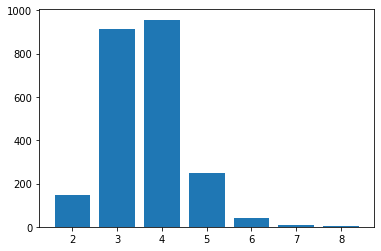

Hardest word(s):  ['boxer', 'hound']
8 rounds 
RANDOM 0 rounds 3 cigar 1
RANDOM 500 rounds 3 enjoy 11
RANDOM 1000 rounds 4 regal 1
RANDOM 1500 rounds 4 dummy 3
RANDOM 2000 rounds 4 bulky 1
RANDOM AVERAGE: 3.820302375809935 +/- 0.04015354202184115


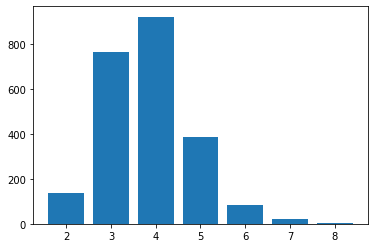

Hardest word(s):  ['pound', 'snore']
8 rounds 
COMMON 0 rounds 2 cigar 102
COMMON 500 rounds 3 enjoy 18
COMMON 1000 rounds 5 regal 4
COMMON 1500 rounds 4 dummy 2
COMMON 2000 rounds 5 bulky 1
COMMON AVERAGE: 3.8786177105831534 +/- 0.042534351010486776


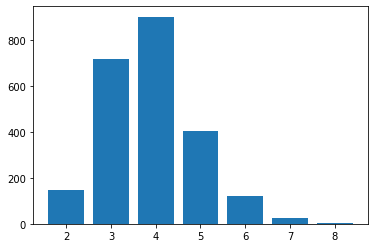

Hardest word(s):  ['tight', 'willy']
8 rounds 


In [13]:
PROD_TARGET = ""
PROD_STRATEGY = ""
INITIAL_GUESS = "salet"

for name, strategy_fn in strategy_dict.items():
  if PROD_STRATEGY and name != PROD_STRATEGY:
    continue

  results = []
  for i, target in enumerate(ALL_CANDIDATES):
    if PROD_TARGET and target != PROD_TARGET:
      continue

    word_df = pd.DataFrame(ALL_CANDIDATES, columns=["words"])
    candidate_df = pd.DataFrame(word_df["words"].map(list).to_list())
    counter = 0
    while True:
      if counter == 0:
        word = INITIAL_GUESS
      else:
        word = strategy_fn(word_df.words.tolist())
      counter += 1
      assert target in word_df.words.tolist(), f"{target} {word_df.words.tolist()}"
      result = evaluate(word, target)
      if result == (2,2,2,2,2):
        results.append([target, counter])
        break

      candidate_df = prune_wordle_candidates(candidate_df, word, result)
      word_df = word_df.loc[candidate_df.index]
      #print(f"{name} {i} rounds {counter} {word} {target} {len(candidate_df)}")
    
    if i % 500 == 0:
      print(f"{name} {i} rounds {counter} {target} {len(candidate_df)}")
  results_df = pd.DataFrame(results, columns=["target", "rounds"])
  print(f"{name} AVERAGE: {results_df.rounds.mean()} +/- {2 * results_df.rounds.sem()}")
  counts_df = results_df.groupby("rounds").count().reset_index()
  plt.bar(counts_df["rounds"], counts_df["target"])
  plt.show()
  print("Hardest word(s): ", results_df.loc[results_df.rounds == results_df.rounds.max(), "target"].tolist())
  print(f"{results_df.rounds.max()} rounds ")

# Solver Program

In [ ]:
PROD_STRATEGY = "PROBABILISTIC"

strategy_fn = strategy_dict[PROD_STRATEGY]
word_df = pd.DataFrame(ALL_CANDIDATES, columns=["words"])
candidate_df = pd.DataFrame(word_df["words"].map(list).to_list())
counter = 0
while True:
  if len(word_df) == 0:
      print("Something went wrong, there are no candidates left...")
      print("Aborting...")
      break

  if counter == 0:
    candidate = INITIAL_GUESS
  else:
    candidate = strategy_fn(word_df.words.tolist())
  counter += 1
  print(
      f"\nCandidates remaining = {len(word_df)}"
      f"\nBest Candidate: {candidate}")

  # parse chosen word from user
  is_valid_word = False
  while not is_valid_word:
    word = input(f"\nEnter your chosen five-letter word (i.e. {candidate}): ")
    is_valid_word = (len(word) == 5)
    if not is_valid_word:
      print("Improper Input!")

  # parse chosen result from user
  is_valid_result = False
  while not is_valid_result:
    result = input(
        "\n0 = Miss, 1 = Partial Match, 2 = Perfect Match "
        "\nEnter your result as a comma-separated list "
        "(i.e. 0,0,0,1,2): ")
    result = tuple(map(int, "".join(result.split()).split(",")))
    is_valid_result = (len(result) == 5) and all([i >= 0 and i <= 2 for i in result])
    if not is_valid_result:
      print("Improper Input!")

  # you won wordle
  if all([i == 2 for i in result]):
    print(f"Congrats! The word was {word}")
    break

  candidate_df = prune_wordle_candidates(candidate_df, word, result)
  word_df = word_df.loc[candidate_df.index]


Candidates remaining = 2315
Best Candidate: crane
